save the data for figures for the Aleutian box;

In [1]:
import os,sys
import numpy as np
import xarray as xr
import zarr
# plot
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from matplotlib.colors import Colormap

# plota
import matplotlib.pyplot as plt
from matplotlib.colors import Colormap
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import matplotlib.cm as cm
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
from matplotlib.colors import from_levels_and_colors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
CB_colors = {
	'blue':	'#377eb8',
	'orange':  '#ff7f00',
	'green':   '#4daf4a',
	'pink':	'#f781bf',
	'brown':   '#a65628',
	'purple':  '#984ea3',
	'gray':	'#999999',
	'red': 	'#e41a1c',
	'yellow':  '#dede00'
}

# from dask.distributed import Client
import multiprocessing.popen_spawn_posix
from distributed import Client

c = Client()
c

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 12,Total memory: 24.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36155,Workers: 0
Dashboard: http://127.0.0.1:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:45029,Total threads: 3
Dashboard: http://127.0.0.1:32843/status,Memory: 6.00 GiB
Nanny: tcp://127.0.0.1:38111,


In [2]:
# diri="/gpfswork/rech/cli/rcli002/eORCA025.L75/eORCA025.L75-I/"
diri = "/gws/nopw/j04/isotipic/stajouri/PhD/Jean_Zay_DIRWORK/uor98hu/"
# mesh_hgr = xr.open_dataset(diri+'mesh_hgr.nc').squeeze
mesh_hgr = xr.open_dataset(diri+'eORCA025.L75_domain_cfg_closed_seas_greenland.nc').squeeze()
# tmask = mesh_hgr.tmask[0].drop_vars('nav_lev').drop_vars('time_counter')
tmask = mesh_hgr.top_level
nav_lon =  mesh_hgr.nav_lon
nav_lat =  mesh_hgr.nav_lat
e1t = mesh_hgr.e1t.fillna(0)
e2t = mesh_hgr.e2t.fillna(0)


In [3]:
dir_sc = "/gws/nopw/j04/isotipic/stajouri/PhD/Jean_Zay_DIRWORK/uor98hu/ETUDE3/ENS_VAR_BUDGET"
dir_work = "/gws/nopw/j04/isotipic/stajouri/PhD/Jean_Zay_DIRWORK/uor98hu/ETUDE3/ENS_VAR_BUDGET"
diro = dir_work + "/PLOTS/"

dir_data = dir_work + "/data4analyses/data4analyses/"
my_regions_masks = xr.open_zarr(dir_data+"my_regions_mask_AI.zarr")
my_regions_masks

<xarray.Dataset> Size: 14MB
Dimensions:  (y: 1207, x: 1442)
Dimensions without coordinates: y, x
Data variables:
    mask_AI  (y, x) float64 14MB dask.array<chunksize=(151, 361), meta=np.ndarray>
Attributes:
    description:  mask Aleutian Islands

In [4]:
# constructing the weight for the Atlantic box
bt = (e1t * e2t).load()# area of each cell
# getting the weights to be applied to every grid cell
# masking the land cells
oceanArea = (bt*tmask).where(my_regions_masks.mask_AI)  #tmask : 1 on ocean, 0 on land
totalOceanArea = oceanArea.sum()
Weight = (oceanArea/totalOceanArea).compute()

/opt/jaspy/lib/python3.12/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 13.29 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


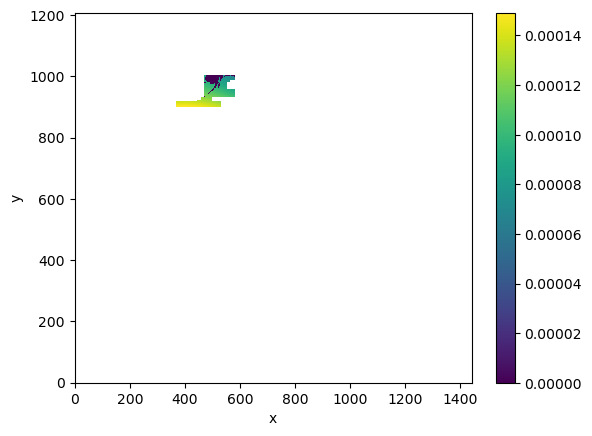

<xarray.DataArray ()> Size: 8B
array(1.)

In [5]:
Weight.plot()
plt.show()
Weight.sum()

# Save for the SLA and the MANO

In [16]:
# %%time

for COMP in ["SLA","MANO"]: # , for MANO: change to '_E_2use_1980_2018.zarr'
    if COMP=="SLA":
        varname = 'SSH_E'
    else:
        varname = COMP+'_E'

    for nexp in ["EAI", 'EGAI']:
        dir_base = dir_work + "/data4analyses/data4analyses/"+nexp+"/"+COMP+"/"
        
        if COMP=="MANO":
            SSH = xr.open_zarr(dir_base+COMP+"_E_2use_1980_2018.zarr")[varname]*100 # in cm
        else:
            SSH = xr.open_zarr(dir_base+COMP+"_2use_1980_2018.zarr")[varname]*100 # in cm

        SSH = (SSH*Weight).sum(('x','y'))
        
        SSH.to_dataset(name="ts_box_AI").to_zarr(dir_base+"time_series_box_AI.zarr", mode='w', zarr_version=2)


/tmp/ipykernel_15244/3610641290.py:19: FutureWarning: zarr_version is deprecated, use zarr_format
  SSH.to_dataset(name="ts_box_AI").to_zarr(dir_base+"time_series_box_AI.zarr", mode='w', zarr_version=2)
/opt/jaspy/lib/python3.12/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 13.32 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/tmp/ipykernel_15244/3610641290.py:19: FutureWarning: zarr_version is deprecated, use zarr_format
  SSH.to_dataset(name="ts_box_AI").to_zarr(dir_base+"time_series_box_AI.zarr", mode='w', zarr_version=2)
/opt/jaspy/lib/python3.12/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 13.32 MiB.
This may cause some slowdown.
Consider loading the data with Dask dir

In [15]:
SSH

<xarray.DataArray (ens: 10, time_counter: 39)> Size: 3kB
dask.array<sum-aggregate, shape=(10, 39), dtype=float64, chunksize=(2, 5), chunktype=numpy.ndarray>
Coordinates:
  * ens           (ens) int64 80B 1 2 3 4 5 6 7 8 9 10
  * time_counter  (time_counter) datetime64[ns] 312B 1980-07-02 ... 2018-07-0...

In [17]:
%%time
central_year = 1999

for COMP in ["SLA", "MANO"]: 
    for nexp in ["EAI", 'EGAI']:
        
        dir_base = dir_work + "/data4analyses/data4analyses/"+nexp+"/"+COMP+"/"

        SSH = xr.open_zarr(dir_base+"time_series_box_AI.zarr").ts_box_AI # in cm
        
        final_matrix = np.zeros((4))

        i = 19
        SSH_period = SSH.sel(time_counter=slice(str(central_year-i),str(central_year+i)))
        TimeMean_SSH = SSH_period.mean('time_counter').compute()
        EnsMean_SSH = SSH_period.mean('ens').compute()
        
        tot_var       = (((SSH_period - TimeMean_SSH)**2).mean("time_counter") ).mean("ens")
        forced_var    = ((EnsMean_SSH - EnsMean_SSH.mean("time_counter"))**2).mean("time_counter")
        intrinsic_var = (((SSH_period - EnsMean_SSH)**2).mean("ens")).mean('time_counter')
        res_var       = ((TimeMean_SSH - TimeMean_SSH.mean('ens'))**2).mean('ens')

        final_matrix[:] = [tot_var.values, forced_var.values, intrinsic_var.values, res_var.values]

        Variance_terms = xr.Dataset(
            data_vars = dict(variances=(["var_term"], final_matrix)),
            coords = dict(
                var_term = (["tot_var","forced_var","intrinsic_var","res_var"]))
                                    )
        Variance_terms.to_zarr(dir_base+"var_terms_box_AI.zarr", mode='w', zarr_version=2)

<timed exec>:29: FutureWarning: zarr_version is deprecated, use zarr_format
<timed exec>:29: FutureWarning: zarr_version is deprecated, use zarr_format
<timed exec>:29: FutureWarning: zarr_version is deprecated, use zarr_format
<timed exec>:29: FutureWarning: zarr_version is deprecated, use zarr_format


CPU times: user 583 ms, sys: 64.8 ms, total: 648 ms
Wall time: 2.66 s


# save the COMP in the Aleutian box time series for (ens, time) and the variance terms for the DEPTHS RANGES

In [7]:
%%time

for COMP in ["STERIC", "THERMO", "HALO"]: # , for MANO: change to '_E_2use_1980_2018.zarr'
    varname = COMP+'_E'

    for nexp in ["EAI", 'EGAI']:
        # dir_base = dir_sc + "/NEW_ENS_VAR_BUDGET/"+nexp+"/"+COMP+"/"
        dir_base = "/work/scratch-pw3/stajouri/STERIC_THERMO_HALO_2use/"+nexp+"/"+COMP+"/"
        
        for dep in ["50m", "100m", "300m", "700m", "2000m", "bottom"]: 
            print(dep)
            SSH = xr.open_zarr(dir_base+COMP+"_0_"+dep+"_2use_1980_2018.zarr")[varname]*100 # in cm
            
            SSH = (SSH*Weight).sum(('x','y'))
            
            SSH.to_dataset(name="ts_box_atl").to_zarr(dir_work + "/data4analyses/data4analyses/"+nexp+"/"+COMP+"/time_series_box_AI_0_"+dep+".zarr",\
                                                      mode='w',zarr_version=2)


50m


<timed exec>:14: FutureWarning: zarr_version is deprecated, use zarr_format
/opt/jaspy/lib/python3.12/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 13.32 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


100m


<timed exec>:14: FutureWarning: zarr_version is deprecated, use zarr_format
/opt/jaspy/lib/python3.12/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 13.32 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


300m


<timed exec>:14: FutureWarning: zarr_version is deprecated, use zarr_format
/opt/jaspy/lib/python3.12/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 13.32 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


700m


<timed exec>:14: FutureWarning: zarr_version is deprecated, use zarr_format
/opt/jaspy/lib/python3.12/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 13.32 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


2000m


<timed exec>:14: FutureWarning: zarr_version is deprecated, use zarr_format
/opt/jaspy/lib/python3.12/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 13.32 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


bottom


<timed exec>:14: FutureWarning: zarr_version is deprecated, use zarr_format
/opt/jaspy/lib/python3.12/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 13.32 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


50m


<timed exec>:14: FutureWarning: zarr_version is deprecated, use zarr_format
/opt/jaspy/lib/python3.12/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 13.32 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


100m


<timed exec>:14: FutureWarning: zarr_version is deprecated, use zarr_format
/opt/jaspy/lib/python3.12/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 13.32 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


300m


<timed exec>:14: FutureWarning: zarr_version is deprecated, use zarr_format
/opt/jaspy/lib/python3.12/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 13.32 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


700m


<timed exec>:14: FutureWarning: zarr_version is deprecated, use zarr_format
/opt/jaspy/lib/python3.12/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 13.32 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


2000m


<timed exec>:14: FutureWarning: zarr_version is deprecated, use zarr_format
/opt/jaspy/lib/python3.12/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 13.32 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


bottom


<timed exec>:14: FutureWarning: zarr_version is deprecated, use zarr_format
/opt/jaspy/lib/python3.12/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 13.32 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


50m


<timed exec>:14: FutureWarning: zarr_version is deprecated, use zarr_format
/opt/jaspy/lib/python3.12/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 13.32 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


100m


<timed exec>:14: FutureWarning: zarr_version is deprecated, use zarr_format
/opt/jaspy/lib/python3.12/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 13.32 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


300m


<timed exec>:14: FutureWarning: zarr_version is deprecated, use zarr_format
/opt/jaspy/lib/python3.12/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 13.32 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


700m


<timed exec>:14: FutureWarning: zarr_version is deprecated, use zarr_format
/opt/jaspy/lib/python3.12/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 13.32 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


2000m


<timed exec>:14: FutureWarning: zarr_version is deprecated, use zarr_format
/opt/jaspy/lib/python3.12/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 13.32 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


bottom


<timed exec>:14: FutureWarning: zarr_version is deprecated, use zarr_format
/opt/jaspy/lib/python3.12/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 13.32 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


50m


<timed exec>:14: FutureWarning: zarr_version is deprecated, use zarr_format
/opt/jaspy/lib/python3.12/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 13.32 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


100m


<timed exec>:14: FutureWarning: zarr_version is deprecated, use zarr_format
/opt/jaspy/lib/python3.12/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 13.32 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


300m


<timed exec>:14: FutureWarning: zarr_version is deprecated, use zarr_format
/opt/jaspy/lib/python3.12/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 13.32 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


700m


<timed exec>:14: FutureWarning: zarr_version is deprecated, use zarr_format
/opt/jaspy/lib/python3.12/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 13.32 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


2000m


<timed exec>:14: FutureWarning: zarr_version is deprecated, use zarr_format
/opt/jaspy/lib/python3.12/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 13.32 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


bottom


<timed exec>:14: FutureWarning: zarr_version is deprecated, use zarr_format
/opt/jaspy/lib/python3.12/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 13.32 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


50m


<timed exec>:14: FutureWarning: zarr_version is deprecated, use zarr_format
/opt/jaspy/lib/python3.12/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 13.32 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


100m


<timed exec>:14: FutureWarning: zarr_version is deprecated, use zarr_format
/opt/jaspy/lib/python3.12/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 13.32 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


300m


<timed exec>:14: FutureWarning: zarr_version is deprecated, use zarr_format
/opt/jaspy/lib/python3.12/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 13.32 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


700m


<timed exec>:14: FutureWarning: zarr_version is deprecated, use zarr_format
/opt/jaspy/lib/python3.12/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 13.32 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


2000m


<timed exec>:14: FutureWarning: zarr_version is deprecated, use zarr_format
/opt/jaspy/lib/python3.12/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 13.32 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


bottom


<timed exec>:14: FutureWarning: zarr_version is deprecated, use zarr_format
/opt/jaspy/lib/python3.12/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 13.32 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


50m


<timed exec>:14: FutureWarning: zarr_version is deprecated, use zarr_format
/opt/jaspy/lib/python3.12/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 13.32 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


100m


<timed exec>:14: FutureWarning: zarr_version is deprecated, use zarr_format
/opt/jaspy/lib/python3.12/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 13.32 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


300m


<timed exec>:14: FutureWarning: zarr_version is deprecated, use zarr_format
/opt/jaspy/lib/python3.12/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 13.32 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


700m


<timed exec>:14: FutureWarning: zarr_version is deprecated, use zarr_format
/opt/jaspy/lib/python3.12/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 13.32 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


2000m


<timed exec>:14: FutureWarning: zarr_version is deprecated, use zarr_format
/opt/jaspy/lib/python3.12/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 13.32 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


bottom


<timed exec>:14: FutureWarning: zarr_version is deprecated, use zarr_format
/opt/jaspy/lib/python3.12/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 13.32 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


CPU times: user 44.4 s, sys: 4.16 s, total: 48.6 s
Wall time: 3min 43s


In [8]:
%%time
central_year = 1999

for COMP in ["STERIC", "THERMO", "HALO"]: 
    for nexp in ["EAI", 'EGAI']:
        
        # dir_base = dir_sc + "/NEW_ENS_VAR_BUDGET/"+nexp+"/"+COMP+"/"
        dir_base = dir_work + "/data4analyses/data4analyses/"+nexp+"/"+COMP+"/"
        
        for dep in ["50m", "100m", "300m", "700m", "2000m", "bottom"]: 
            print(dep)
            SSH = xr.open_zarr(dir_base+"time_series_box_AI_0_"+dep+".zarr").ts_box_atl # in cm
            
            # final_matrix = np.zeros((20,4))
            final_matrix = np.zeros((4))

            # for i in np.arange(20):
            i = 19
            SSH_period = SSH.sel(year=slice(str(central_year-i),str(central_year+i)))
            TimeMean_SSH = SSH_period.mean('year').compute()
            EnsMean_SSH = SSH_period.mean('ens').compute()
            
            tot_var       = (((SSH_period - TimeMean_SSH)**2).mean("year") ).mean("ens")
            forced_var    = ((EnsMean_SSH - EnsMean_SSH.mean("year"))**2).mean("year")
            intrinsic_var = (((SSH_period - EnsMean_SSH)**2).mean("ens")).mean('year')
            res_var       = ((TimeMean_SSH - TimeMean_SSH.mean('ens'))**2).mean('ens')
    
            final_matrix[:] = [tot_var.values, forced_var.values, intrinsic_var.values, res_var.values]
    
            # create dataset and save
            # Variance_terms = xr.Dataset(
            #     data_vars = dict(variances=(["time_length", "var_term"], final_matrix)),
            #     coords = dict(
            #         time_length = ("time_length", [str(1+ i*2) for i in np.arange(20)]),
            #         var_term = ("var_term", ["tot_var","forced_var","intrinsic_var","res_var"]))
            
            Variance_terms = xr.Dataset(
                data_vars = dict(variances=(["var_term"], final_matrix)),
                coords = dict(
                    var_term = (["tot_var","forced_var","intrinsic_var","res_var"]))
                                        )
            Variance_terms.to_zarr(dir_base+"var_terms_box_AI_0_"+dep+".zarr", mode='w', zarr_version=2)

50m


<timed exec>:41: FutureWarning: zarr_version is deprecated, use zarr_format


100m


<timed exec>:41: FutureWarning: zarr_version is deprecated, use zarr_format


300m


<timed exec>:41: FutureWarning: zarr_version is deprecated, use zarr_format


700m


<timed exec>:41: FutureWarning: zarr_version is deprecated, use zarr_format


2000m


<timed exec>:41: FutureWarning: zarr_version is deprecated, use zarr_format


bottom


<timed exec>:41: FutureWarning: zarr_version is deprecated, use zarr_format


50m


<timed exec>:41: FutureWarning: zarr_version is deprecated, use zarr_format


100m


<timed exec>:41: FutureWarning: zarr_version is deprecated, use zarr_format


300m


<timed exec>:41: FutureWarning: zarr_version is deprecated, use zarr_format


700m


<timed exec>:41: FutureWarning: zarr_version is deprecated, use zarr_format


2000m


<timed exec>:41: FutureWarning: zarr_version is deprecated, use zarr_format


bottom


<timed exec>:41: FutureWarning: zarr_version is deprecated, use zarr_format


50m


<timed exec>:41: FutureWarning: zarr_version is deprecated, use zarr_format


100m


<timed exec>:41: FutureWarning: zarr_version is deprecated, use zarr_format


300m


<timed exec>:41: FutureWarning: zarr_version is deprecated, use zarr_format


700m


<timed exec>:41: FutureWarning: zarr_version is deprecated, use zarr_format


2000m


<timed exec>:41: FutureWarning: zarr_version is deprecated, use zarr_format


bottom


<timed exec>:41: FutureWarning: zarr_version is deprecated, use zarr_format


50m


<timed exec>:41: FutureWarning: zarr_version is deprecated, use zarr_format


100m


<timed exec>:41: FutureWarning: zarr_version is deprecated, use zarr_format


300m


<timed exec>:41: FutureWarning: zarr_version is deprecated, use zarr_format


700m


<timed exec>:41: FutureWarning: zarr_version is deprecated, use zarr_format


2000m


<timed exec>:41: FutureWarning: zarr_version is deprecated, use zarr_format


bottom


<timed exec>:41: FutureWarning: zarr_version is deprecated, use zarr_format


50m


<timed exec>:41: FutureWarning: zarr_version is deprecated, use zarr_format


100m


<timed exec>:41: FutureWarning: zarr_version is deprecated, use zarr_format


300m


<timed exec>:41: FutureWarning: zarr_version is deprecated, use zarr_format


700m


<timed exec>:41: FutureWarning: zarr_version is deprecated, use zarr_format


2000m


<timed exec>:41: FutureWarning: zarr_version is deprecated, use zarr_format


bottom


<timed exec>:41: FutureWarning: zarr_version is deprecated, use zarr_format


50m


<timed exec>:41: FutureWarning: zarr_version is deprecated, use zarr_format


100m


<timed exec>:41: FutureWarning: zarr_version is deprecated, use zarr_format


300m


<timed exec>:41: FutureWarning: zarr_version is deprecated, use zarr_format


700m


<timed exec>:41: FutureWarning: zarr_version is deprecated, use zarr_format


2000m


<timed exec>:41: FutureWarning: zarr_version is deprecated, use zarr_format


bottom


<timed exec>:41: FutureWarning: zarr_version is deprecated, use zarr_format


CPU times: user 5.77 s, sys: 634 ms, total: 6.41 s
Wall time: 31.2 s
